In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from imutils import paths
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_resource_variable_ops
from tensorflow.python.training import gen_training_ops
from tensorflow.python.util.tf_export import keras_export



In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
	def __init__(self, dataFormat=None):
		self.dataFormat = dataFormat

	def preprocess(self, image):
		return img_to_array(image, data_format=self.dataFormat)

In [ ]:
import imutils
import cv2

class AspectAwarePreprocessor:
	def __init__(self, width, height, inter=cv2.INTER_AREA):
		self.width = width
		self.height = height
		self.inter = inter

	def preprocess(self, image):
		(h, w) = image.shape[:2]
		dW = 0
		dH = 0


		if w < h:
			image = imutils.resize(image, width=self.width,
				inter=self.inter)
			dH = int((image.shape[0] - self.height) / 2.0)

		else:
			image = imutils.resize(image, height=self.height,
				inter=self.inter)
			dW = int((image.shape[1] - self.width) / 2.0)

		(h, w) = image.shape[:2]
		image = image[dH:h - dH, dW:w - dW]

		return cv2.resize(image, (self.width, self.height),
			interpolation=self.inter)

In [ ]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")




In [ ]:
from tensorflow.python.framework import ops
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_resource_variable_ops
from tensorflow.python.training import gen_training_ops
from tensorflow.python.util.tf_export import keras_export

class SGD(optimizer_v2.OptimizerV2):
 
  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
               learning_rate=0.01,
               momentum=0.0,
               nesterov=False,
               name="SGD",
               **kwargs):
    super(SGD, self).__init__(name, **kwargs)
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
    self._set_hyper("decay", self._initial_decay)

    self._momentum = False
    if isinstance(momentum, ops.Tensor) or callable(momentum) or momentum > 0:
      self._momentum = True
    if isinstance(momentum, (int, float)) and (momentum < 0 or momentum > 1):
      raise ValueError("`momentum` must be between [0, 1].")
    self._set_hyper("momentum", momentum)

    self.nesterov = nesterov

  def _create_slots(self, var_list):
    if self._momentum:
      for var in var_list:
        self.add_slot(var, "momentum")

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(SGD, self)._prepare_local(var_device, var_dtype, apply_state)
    apply_state[(var_device, var_dtype)]["momentum"] = array_ops.identity(
        self._get_hyper("momentum", var_dtype))

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    if self._momentum:
      momentum_var = self.get_slot(var, "momentum")
      return gen_training_ops.ResourceApplyKerasMomentum(
          var=var.handle,
          accum=momentum_var.handle,
          lr=coefficients["lr_t"],
          grad=grad,
          momentum=coefficients["momentum"],
          use_locking=self._use_locking,
          use_nesterov=self.nesterov)
    else:
      return gen_training_ops.ResourceApplyGradientDescent(
          var=var.handle,
          alpha=coefficients["lr_t"],
          delta=grad,
          use_locking=self._use_locking)

  def _resource_apply_sparse_duplicate_indices(self, grad, var, indices,
                                               **kwargs):
    if self._momentum:
      return super(SGD, self)._resource_apply_sparse_duplicate_indices(
          grad, var, indices, **kwargs)
    else:
      var_device, var_dtype = var.device, var.dtype.base_dtype
      coefficients = (kwargs.get("apply_state", {}).get((var_device, var_dtype))
                      or self._fallback_apply_state(var_device, var_dtype))

      return gen_resource_variable_ops.ResourceScatterAdd(
          resource=var.handle,
          indices=indices,
          updates=-grad * coefficients["lr_t"])

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    # This method is only needed for momentum optimization.
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    momentum_var = self.get_slot(var, "momentum")
    return gen_training_ops.ResourceSparseApplyKerasMomentum(
        var=var.handle,
        accum=momentum_var.handle,
        lr=coefficients["lr_t"],
        grad=grad,
        indices=indices,
        momentum=coefficients["momentum"],
        use_locking=self._use_locking,
        use_nesterov=self.nesterov)

  def get_config(self):
    config = super(SGD, self).get_config()
    config.update({
        "learning_rate": self._serialize_hyperparameter("learning_rate"),
        "decay": self._serialize_hyperparameter("decay"),
        "momentum": self._serialize_hyperparameter("momentum"),
        "nesterov": self.nesterov,
    })
    return config


from tensorflow.python.eager import def_function
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.training import gen_training_ops
from tensorflow.python.util.tf_export import keras_export

class Adam(optimizer_v2.OptimizerV2):
 

  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
               learning_rate=0.001,
               beta_1=0.9,
               beta_2=0.999,
               epsilon=1e-7,
               amsgrad=False,
               name='Adam',
               **kwargs):
    super(Adam, self).__init__(name, **kwargs)
    self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
    self._set_hyper('decay', self._initial_decay)
    self._set_hyper('beta_1', beta_1)
    self._set_hyper('beta_2', beta_2)
    self.epsilon = epsilon or backend_config.epsilon()
    self.amsgrad = amsgrad

  def _create_slots(self, var_list):
    for var in var_list:
      self.add_slot(var, 'm')
    for var in var_list:
      self.add_slot(var, 'v')
    if self.amsgrad:
      for var in var_list:
        self.add_slot(var, 'vhat')

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(Adam, self)._prepare_local(var_device, var_dtype, apply_state)

    local_step = math_ops.cast(self.iterations + 1, var_dtype)
    beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
    beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
    beta_1_power = math_ops.pow(beta_1_t, local_step)
    beta_2_power = math_ops.pow(beta_2_t, local_step)
    lr = (apply_state[(var_device, var_dtype)]['lr_t'] *
          (math_ops.sqrt(1 - beta_2_power) / (1 - beta_1_power)))
    apply_state[(var_device, var_dtype)].update(
        dict(
            lr=lr,
            epsilon=ops.convert_to_tensor_v2_with_dispatch(
                self.epsilon, var_dtype),
            beta_1_t=beta_1_t,
            beta_1_power=beta_1_power,
            one_minus_beta_1_t=1 - beta_1_t,
            beta_2_t=beta_2_t,
            beta_2_power=beta_2_power,
            one_minus_beta_2_t=1 - beta_2_t))

  def set_weights(self, weights):
    params = self.weights
    num_vars = int((len(params) - 1) / 2)
    if len(weights) == 3 * num_vars + 1:
      weights = weights[:len(params)]
    super(Adam, self).set_weights(weights)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    m = self.get_slot(var, 'm')
    v = self.get_slot(var, 'v')

    if not self.amsgrad:
      return gen_training_ops.ResourceApplyAdam(
          var=var.handle,
          m=m.handle,
          v=v.handle,
          beta1_power=coefficients['beta_1_power'],
          beta2_power=coefficients['beta_2_power'],
          lr=coefficients['lr_t'],
          beta1=coefficients['beta_1_t'],
          beta2=coefficients['beta_2_t'],
          epsilon=coefficients['epsilon'],
          grad=grad,
          use_locking=self._use_locking)
    else:
      vhat = self.get_slot(var, 'vhat')
      return gen_training_ops.ResourceApplyAdamWithAmsgrad(
          var=var.handle,
          m=m.handle,
          v=v.handle,
          vhat=vhat.handle,
          beta1_power=coefficients['beta_1_power'],
          beta2_power=coefficients['beta_2_power'],
          lr=coefficients['lr_t'],
          beta1=coefficients['beta_1_t'],
          beta2=coefficients['beta_2_t'],
          epsilon=coefficients['epsilon'],
          grad=grad,
          use_locking=self._use_locking)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    # m_t = beta1 * m + (1 - beta1) * g_t
    m = self.get_slot(var, 'm')
    m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
    m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                           use_locking=self._use_locking)
    with ops.control_dependencies([m_t]):
      m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

    # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
    v = self.get_slot(var, 'v')
    v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
    v_t = state_ops.assign(v, v * coefficients['beta_2_t'],
                           use_locking=self._use_locking)
    with ops.control_dependencies([v_t]):
      v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

    if not self.amsgrad:
      v_sqrt = math_ops.sqrt(v_t)
      var_update = state_ops.assign_sub(
          var, coefficients['lr'] * m_t / (v_sqrt + coefficients['epsilon']),
          use_locking=self._use_locking)
      return control_flow_ops.group(*[var_update, m_t, v_t])
    else:
      v_hat = self.get_slot(var, 'vhat')
      v_hat_t = math_ops.maximum(v_hat, v_t)
      with ops.control_dependencies([v_hat_t]):
        v_hat_t = state_ops.assign(
            v_hat, v_hat_t, use_locking=self._use_locking)
      v_hat_sqrt = math_ops.sqrt(v_hat_t)
      var_update = state_ops.assign_sub(
          var,
          coefficients['lr'] * m_t / (v_hat_sqrt + coefficients['epsilon']),
          use_locking=self._use_locking)
      return control_flow_ops.group(*[var_update, m_t, v_t, v_hat_t])

  def get_config(self):
    config = super(Adam, self).get_config()
    config.update({
        'learning_rate': self._serialize_hyperparameter('learning_rate'),
        'decay': self._serialize_hyperparameter('decay'),
        'beta_1': self._serialize_hyperparameter('beta_1'),
        'beta_2': self._serialize_hyperparameter('beta_2'),
        'epsilon': self.epsilon,
        'amsgrad': self.amsgrad,
    })
    return config




In [ ]:
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D

In [ ]:

 
class VGG16:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = +1

    # # first CONV => RELU => CONV => RELU => POOL layer set
    # model.add(Conv2D(32, (3, 3), padding="same",
    # 	input_shape=inputShape))
    # model.add(Activation("relu"))
    # model.add(BatchNormalization(axis=chanDim))
    # model.add(Conv2D(32, (3, 3), padding="same"))
    # model.add(Activation("relu"))
    # model.add(BatchNormalization(axis=chanDim))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))

    # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

      # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

      # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

      # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(512, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model


In [ ]:

 
class VGG16:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    

    model = Sequential()
    model.add(Conv2D(input_shape=inputShape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model




In [ ]:
model = VGG16.build(224,224, 3, 11)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)      

In [ ]:
class VGG16:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [ ]:
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
	def __init__(self, preprocessors=None):
		self.preprocessors = preprocessors

		if self.preprocessors is None:
			self.preprocessors = []

	def load(self, imagePaths, verbose=-1):
		data = []
		labels = []

		for (i, imagePath) in enumerate(imagePaths):
			image = cv2.imread(imagePath)
			label = imagePath.split(os.path.sep)[-2]

			if self.preprocessors is not None:
				for p in self.preprocessors:
					image = p.preprocess(image)

			data.append(image)
			labels.append(label)

			if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
				print("[INFO] processed {}/{}".format(i + 1,
					len(imagePaths)))

		return (np.array(data), np.array(labels))

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("drive/MyDrive/data/"))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

aap = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()

sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
(data, labels) = sdl.load(imagePaths, verbose=100)
data = data.astype("float") / 255.0


[INFO] loading images...
[INFO] processed 100/3340
[INFO] processed 200/3340
[INFO] processed 300/3340
[INFO] processed 400/3340
[INFO] processed 500/3340
[INFO] processed 600/3340
[INFO] processed 700/3340
[INFO] processed 800/3340
[INFO] processed 900/3340
[INFO] processed 1000/3340
[INFO] processed 1100/3340
[INFO] processed 1200/3340
[INFO] processed 1300/3340
[INFO] processed 1400/3340
[INFO] processed 1500/3340
[INFO] processed 1600/3340
[INFO] processed 1700/3340
[INFO] processed 1800/3340
[INFO] processed 1900/3340
[INFO] processed 2000/3340
[INFO] processed 2100/3340
[INFO] processed 2200/3340
[INFO] processed 2300/3340
[INFO] processed 2400/3340
[INFO] processed 2500/3340
[INFO] processed 2600/3340
[INFO] processed 2700/3340
[INFO] processed 2800/3340
[INFO] processed 2900/3340
[INFO] processed 3000/3340
[INFO] processed 3100/3340
[INFO] processed 3200/3340
[INFO] processed 3300/3340


In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.35, random_state=42)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)





In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
model = VGG16.build(224,224, 3, 11)
model.summary()
print("[INFO] compiling model...")
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] training head...")
Hi = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),validation_data=(testX, testY), epochs=20,steps_per_epoch=len(trainX) // 32, verbose=1)

print("[INFO] evaluating after initialization...")
prediction = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	prediction.argmax(axis=1), target_names=classNames))
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), Hi.history["loss"],'g', label="train_loss")
plt.plot(np.arange(0, 20), Hi.history["val_loss"],'m', label="val_loss")
plt.title("Training Loss on penta cancer")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), Hi.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), Hi.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy on penta cancer")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
print("[INFO] re-compiling model...")
opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] fine-tuning model...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
	validation_data=(testX, testY), epochs=20,
	steps_per_epoch=len(trainX) // 32, verbose=1)

for key in H.history.keys():
    print(key)
print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=classNames))

print("[INFO] serializing model...")
model.save("output.model")

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"],'g',label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"],'m', label="val_loss")
plt.title("Training Loss on penta cancer")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy on penta cancer")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()
plt.savefig("output.png")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20


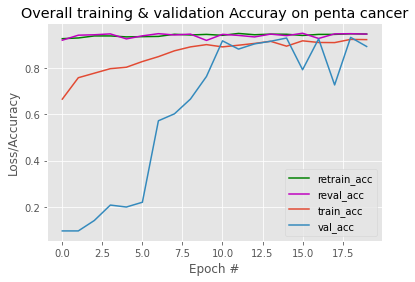

In [ ]:
e=np.arange(0,20)
plt.plot(e, H.history["accuracy"],'g', label="retrain_acc")
plt.plot(e, H.history["val_accuracy"],'m', label="reval_acc")
plt.plot(e, Hi.history["accuracy"], label="train_acc")
plt.plot(e, Hi.history["val_accuracy"], label="val_acc")
plt.title("Overall training & validation Accuray on penta cancer")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

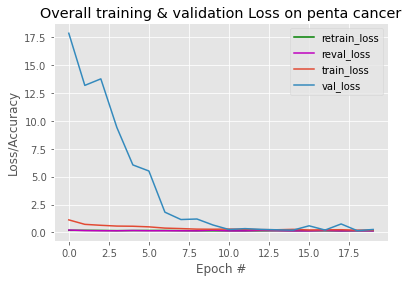

In [ ]:
e=np.arange(0,20)
plt.plot(e, H.history["loss"],'g', label="retrain_loss")
plt.plot(e, H.history["val_loss"],'m', label="reval_loss")
plt.plot(e, Hi.history["loss"], label="train_loss")
plt.plot(e, Hi.history["val_loss"], label="val_loss")
plt.title("Overall training & validation Loss on penta cancer")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
model = VGG16.build(224,224, 3, 11)
model.summary()

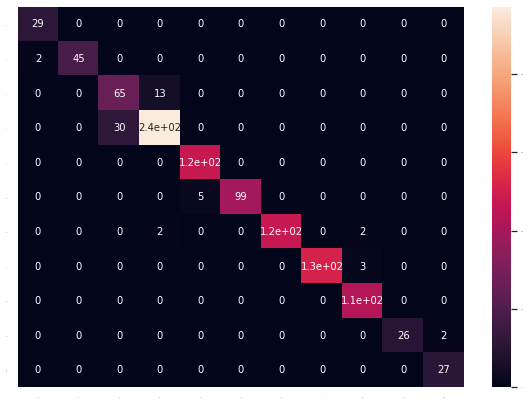

In [ ]:
#from sklearn.metrics import confusion_matrix
predIdxs = np.argmax(predictions, axis=1)
rounded_labels=np.argmax(testY, axis=1)
#print(classNames)
cm = confusion_matrix(rounded_labels, predIdxs)

#import seaborn as sn
#import pandas as pd
#import matplotlib.pyplot as plt
#print(cm)

df_cm = pd.DataFrame(cm, range(11), range(11))
plt.figure(figsize=(10,7))
sn.set(font_scale=0.1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
#sn.heatmap(df_cm)

plt.show()

In [ ]:
df_cm

,0,1,2,3,4,5,6,7,8,9,10
0,29,0,0,0,0,0,0,0,0,0,0
1,2,45,0,0,0,0,0,0,0,0,0
2,0,0,65,13,0,0,0,0,0,0,0
3,0,0,30,243,0,0,0,0,0,0,0
4,0,0,0,0,119,0,0,0,0,0,0
5,0,0,0,0,5,99,0,0,0,0,0
6,0,0,0,2,0,0,119,0,2,0,0
7,0,0,0,0,0,0,0,129,3,0,0
8,0,0,0,0,0,0,0,0,109,0,0
9,0,0,0,0,0,0,0,0,0,26,2


In [ ]:
!pip install flask-ngrok
!pip install flask_cors


In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask
from flask import Flask, app,request
from base64 import b64decode
import json
import os
import cv2
from imutils import paths
import base64
import numpy as np
import numpy
import sys
from flask import jsonify
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import requests
import pickle
from imutils.video import VideoStream
from imutils import paths
from threading import Thread
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from datetime import datetime
from datetime import date
import numpy as np
import argparse
import imutils
import pickle
import time
import cv2
import os
from base64 import b64decode
import base64
import io
from flask_cors import CORS, cross_origin


app = Flask(__name__)
cors = CORS(app)
run_with_ngrok(app)   
@app.route('/penta', methods=['GET','POST'])
# @cross_origin()
def login():
    result = input(request.json['uri'])
    print("sfvnvjknb")
    return result
    

def input(uri):
    print("[INFO] loading model...")
    model = load_model(str("drive/MyDrive/new30e.model"))
    imagePaths = list(paths.list_images("drive/MyDrive/penta_dataset/"))
    classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
    classNames = [str(x) for x in np.unique(classNames)]
    uri = uri
    header, encoded = uri.split(",", 1)
    data = b64decode(encoded)
    f = open("uriimage.png", "wb")
    f.write(data)
    frame = cv2.imread("uriimage.png")
    timestamp = datetime.now()
    frame = imutils.resize(frame, width=400)
    frame = cv2.flip(frame, 1)
    roi = cv2.resize(frame, (224, 224))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    proba = model.predict(roi)[0]
    label = classNames[proba.argmax()]
    print(label)
    return ({"data":label})

if __name__ == '__main__':
    app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://fe44a2c78162.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [12/Apr/2021 04:20:27] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [12/Apr/2021 04:20:42] "POST /penta HTTP/1.1" 200 -


lung_normal
sfvnvjknb


127.0.0.1 - - [12/Apr/2021 04:21:06] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [12/Apr/2021 04:21:10] "POST /penta HTTP/1.1" 200 -


breast_cancer
sfvnvjknb


127.0.0.1 - - [12/Apr/2021 04:25:20] "OPTIONS /penta HTTP/1.1" 200 -


[INFO] loading model...


127.0.0.1 - - [12/Apr/2021 04:25:24] "POST /penta HTTP/1.1" 200 -


brain_tumour
sfvnvjknb
